In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt

In [2]:
# Seleziona la regione da plottare (eg: "Italia", "Lombardia", "Emilia Romanga"...)
regione = "Italia" 

In [3]:
# Carichiamo i dati dal sito della protezione civile
if regione.lower() == "italia":
    url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
else: 
    url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
    
df = pd.read_csv(url)

if regione.lower() != "italia":
    # Selezioniamo la regione
    df = df[df.denominazione_regione==regione]
    df = df.reset_index(drop=True)

In [4]:
# estraiamo la data e convertiamola in un formato compatto
data = df['data']
data_str = data.map(lambda x : x[5:10])

# definiamo i colori per i plot
colors = ["#1f77b4","#FF9933", "#CC0000", "#990000" ]
#         infetti,  ospedaliz., terap.int, morti

In [5]:
# Aggiungiamo il dato "nuovi_casi"
df['nuovi_casi'] = np.diff(df['totale_casi'],prepend=df['totale_casi'][0])
#NB i dati partano da diffusione già iniziata, quindi ho imposto il primo giorno 
# a zero nuovi casi. In alternativa usare il comando seguente:
#df['nuovi_casi'] = np.diff(df['totale_casi'],prepend=0)

# Calcoliamo il numero di decessi per giorno
df['nuovi_morti'] = np.diff(df['deceduti'],prepend=0)

# Colcoliamo la percentuale di ricoverati ed in terapia intensiva
pct_osp = 100.0*df["totale_ospedalizzati"]/df["totale_attualmente_positivi"]
pct_int = 100.0*df["terapia_intensiva"]/df["totale_attualmente_positivi"]
#pct_casa = 100.0*df["isolamento_domiciliare"]/df["totale_attualmente_positivi"]

# Calcoliamo il tasso di letalità
letalità = 100.0* df.iloc[-1]["deceduti"] / df.iloc[-1]["totale_casi"]

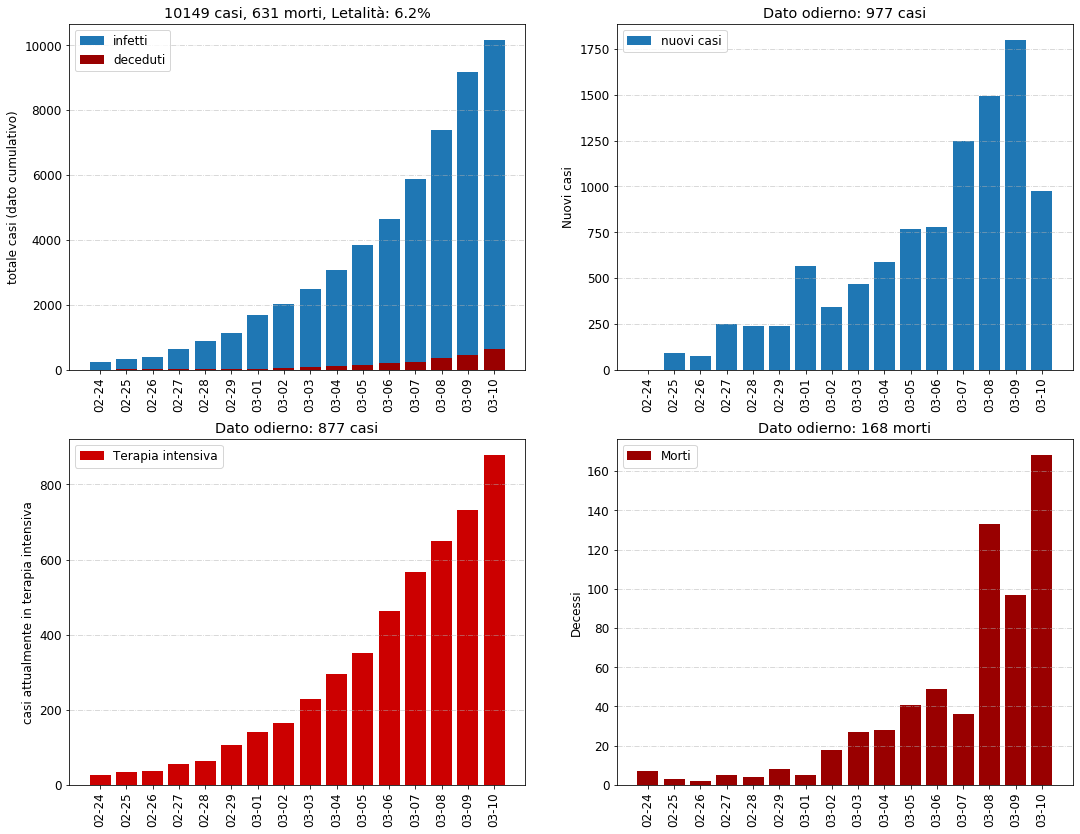

In [6]:
plt.rcParams['figure.figsize'] = [18, 14]
plt.rc('font', size=12)

def plot_common():
    plt.xticks(rotation=90)
    plt.grid(True,axis='y',which='both',linestyle='-.',alpha=0.6)
    plt.legend()

# Casi totali (dato cumulativo)
plt.subplot(2,2,1)
plt.bar(data_str,df['totale_casi'],label="infetti",color=colors[0])
plt.bar(data_str,df['deceduti'],color=colors[3],label="deceduti")
plot_common()
plt.ylabel("totale casi (dato cumulativo)")
#plt.title(["Ad oggi: "] + str(df.iloc[-1]["totale_casi"])
plt.title(str(df.iloc[-1]["totale_casi"]) + " casi, " + str(df.iloc[-1]["deceduti"]) + " morti, Letalità: " +  "{:.1f}".format(letalità) + "%")

# Nuovi casi registrati
plt.subplot(2,2,2)
plt.bar(data_str,df['nuovi_casi'],color=colors[0],label="nuovi casi")
plot_common()
plt.ylabel("Nuovi casi")
plt.title("Dato odierno: " + str(df.iloc[-1]["nuovi_casi"]) + " casi")

# Casi attualmente in terapia intensiva
ax = plt.subplot(2,2,3)
plt.bar(data_str,df['terapia_intensiva'],color=colors[2],label="Terapia intensiva")
plot_common()
plt.ylabel("casi attualmente in terapia intensiva")
plt.title("Dato odierno: " + str(df.iloc[-1]["terapia_intensiva"]) + " casi");

# Deceduti giornalmente
ax = plt.subplot(2,2,4)
plt.bar(data_str,df['nuovi_morti'],color=colors[3],label="Morti")
plot_common()
plt.ylabel("Decessi")
plt.title("Dato odierno: " + str(df.iloc[-1]['nuovi_morti']) + " morti");

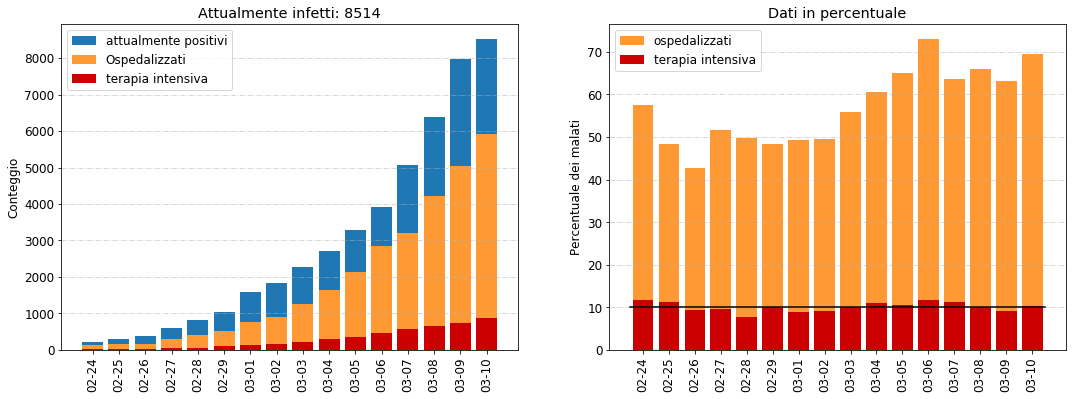

In [7]:
plt.rcParams['figure.figsize'] = [18, 6]
plt.rc('font', size=12)

# Plottiamo il numero degli attualmente infetti, distinguendo tra ospedalizzati ed in terapia intensiva  
plt.subplot(1,2,1)
plt.bar(data_str,df['totale_attualmente_positivi'],label="attualmente positivi",color=colors[0])
plt.bar(data_str,df['totale_ospedalizzati'],label="Ospedalizzati",color=colors[1])
plt.bar(data_str,df['terapia_intensiva'],label="terapia intensiva",color=colors[2])
plt.title('Attualmente infetti: ' + str(df.iloc[-1]["totale_attualmente_positivi"]))
plot_common()
plt.ylabel("Conteggio")

# Plottiamo la percentuale degli infetti che richiedo assitenza medica o terapia intensiva
plt.subplot(1,2,2)
plt.bar(data_str,pct_osp,label="ospedalizzati",color=colors[1])
plt.bar(data_str,pct_int,label="terapia intensiva",color=colors[2])
plt.plot([-.5,(len(data_str)-.5)],[10,10],color='black')
plt.title('Dati in percentuale')
plot_common()
plt.ylabel("Percentuale dei malati");


In [8]:
# Calcoliamo il "Growth Factor" ( = nuovi_casi(t)/nuovi_casi(t-1)) che se maggiore di 1 
# è indicativo di una possible crescita esponenziale
growth_factor =  []
for i in range(1,len(df["nuovi_casi"])):
    if df["nuovi_casi"][i-1] !=0:
        growth_factor.append(df["nuovi_casi"][i]/df["nuovi_casi"][i-1])
    else:
        growth_factor.append(np.nan)
#add an empty value for the initial date
growth_factor.insert(0,np.nan)


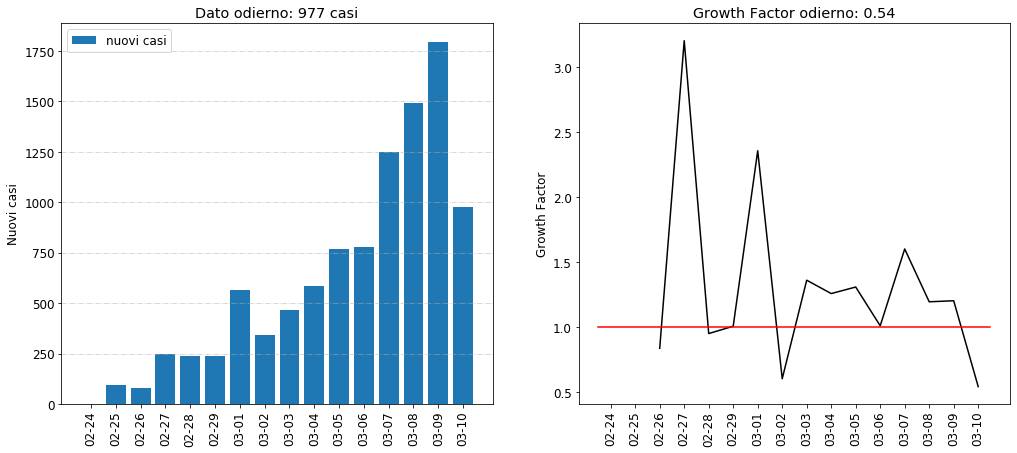

In [9]:
plt.rcParams['figure.figsize'] = [17, 7]
plt.rc('font', size=12)

# Riplottiamo i nuovi casi registrati
plt.subplot(1,2,1)
plt.bar(data_str,df['nuovi_casi'],color=colors[0],label="nuovi casi")
plot_common()
plt.ylabel("Nuovi casi")
plt.title("Dato odierno: " + str(df.iloc[-1]["nuovi_casi"]) + " casi")

# Growth factor
plt.subplot(1,2,2)
plt.plot(data_str,growth_factor,color="black")
plt.plot([-.5,(len(data_str)-.5)],[1,1],color='red')
plt.xticks(rotation=90)
plt.ylabel("Growth Factor")
plt.title("Growth Factor odierno: " + "{:.2f}".format(growth_factor[-1]));